# Summary : File for training the  posenet coordinates and generating the model for classification.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# first neural network with keras make predictions
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.optimizers import SGD, Adam, Adadelta, RMSprop

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [5]:
#Provide link to the dataset from google drive. 
df = pd.read_csv("dataset.csv")

In [6]:
df.head()

,Unnamed: 0,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,target
0,0,0.649173,0.523219,0.657339,0.503735,0.655636,0.504516,0.630299,0.455352,0.636445,...,0.666943,0.540174,0.773534,0.539856,0.762104,0.699938,0.878527,0.673206,0.852668,downdog
1,1,0.655792,0.575658,0.660437,0.590248,0.655015,0.590673,0.636295,0.615927,0.623701,...,0.426795,0.543175,0.299537,0.544742,0.302838,0.675126,0.180818,0.675930,0.177933,downdog
2,2,0.659473,0.599582,0.660218,0.620654,0.662387,0.619791,0.615932,0.658006,0.614723,...,0.379610,0.537431,0.221986,0.542609,0.222733,0.732093,0.105802,0.746955,0.084199,downdog
3,3,0.671158,0.542812,0.679293,0.560280,0.676892,0.559193,0.651990,0.601257,0.644605,...,0.411304,0.529392,0.294301,0.532135,0.295052,0.703284,0.193187,0.710546,0.181630,downdog
4,4,0.607264,0.357824,0.612975,0.337642,0.614474,0.339381,0.570222,0.307927,0.576377,...,0.563056,0.485910,0.705451,0.492973,0.701507,0.673677,0.831081,0.666935,0.816390,downdog


In [7]:
df.index = df['Unnamed: 0']
df.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
#Cleaning the data => Removing columns with nose, ear and eye
points_to_remove = ['nose','ear','eye']
for c in df.columns:
       for point in points_to_remove:
         if(point in c):
           print("Drop : ",c)
           df.drop(c, axis=1, inplace=True)

Drop :  nose_x
Drop :  nose_y
Drop :  left_eye_x
Drop :  left_eye_y
Drop :  right_eye_x
Drop :  right_eye_y
Drop :  left_ear_x
Drop :  left_ear_y
Drop :  right_ear_x
Drop :  right_ear_y


In [9]:
df.shape
#25 columns in the data frame => taking 24 co ordinates to detect a pose

(470, 25)

In [10]:
df.columns

Index(['left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x',
       'right_shoulder_y', 'left_elbow_x', 'left_elbow_y', 'right_elbow_x',
       'right_elbow_y', 'left_wrist_x', 'left_wrist_y', 'right_wrist_x',
       'right_wrist_y', 'left_hip_x', 'left_hip_y', 'right_hip_x',
       'right_hip_y', 'left_knee_x', 'left_knee_y', 'right_knee_x',
       'right_knee_y', 'left_ankle_x', 'left_ankle_y', 'right_ankle_x',
       'right_ankle_y', 'target'],
      dtype='object')

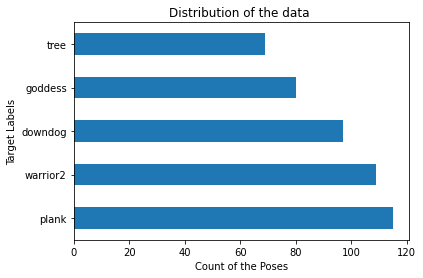

In [11]:
#Showing the number of images present for each yoga pose 
df.target.value_counts().plot(kind='barh')
plt.title("Distribution of the data ")
plt.xlabel("Count of the Poses")
plt.ylabel("Target Labels")
plt.show()

In [12]:
#Separating input(X=>all the coordinates of joints) and output(Y=>pose) data 
X = df.drop(columns=['target'])
y_temp = df['target']

In [13]:
#Encoding the target variables with labels for each class 
le = preprocessing.LabelEncoder()
y = le.fit_transform(y_temp)

In [14]:
#showing labels assigned to each pose 
poses = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
encoded_data, mapping_index = pd.Series(poses).factorize()
for data in encoded_data:
    print(data, mapping_index[data])

0 downdog
1 goddess
2 plank
3 tree
4 warrior2


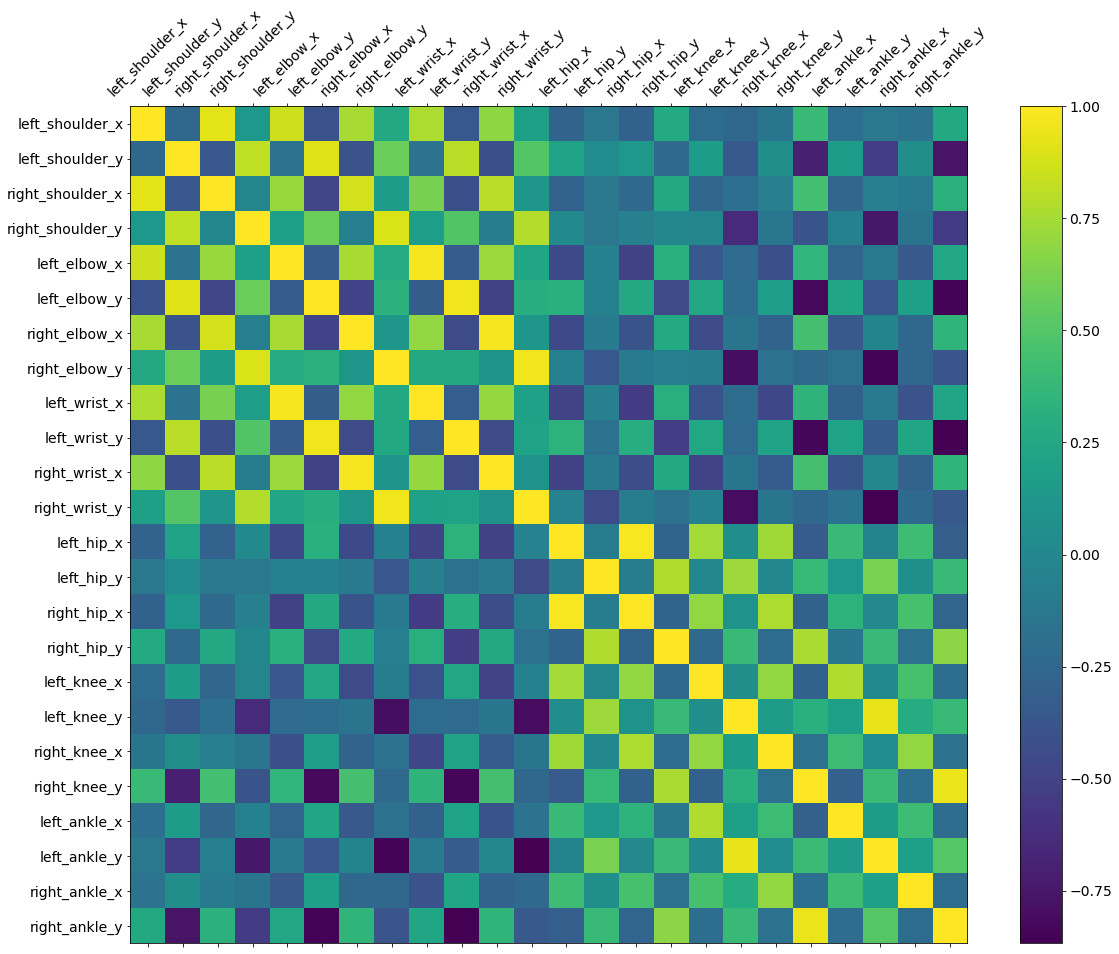

In [71]:
#plotting the correlation matrix 
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
search = '_x'

plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

#Training Model

In [15]:
#splitting the train and test datas 
X_dev, X_test, y_dev, y_test = train_test_split( X, y, test_size=0.20, random_state=42)
#Splitting the data into validation and train test
X_train, X_val, y_train, y_val = train_test_split( X_dev, y_dev, test_size=0.20, random_state=42)

In [16]:
print("Shape of the dataset")
print("Train ", X_train.shape)
print("Test ", X_test.shape)
print("Validation ", X_val.shape)
input_shape = X_train.shape

Shape of the dataset
Train  (300, 24)
Test  (94, 24)
Validation  (76, 24)


In [27]:
#Building custom model 
model = Sequential()
model.add(Dense(32,  activation = "relu"))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(32, activation = "relu"))
model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(32, activation = "softmax"))
model.compile(Adam(lr = 0.01), "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [28]:
model.build(input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (300, 32)                 800       
_________________________________________________________________
dense_13 (Dense)             (300, 128)                4224      
_________________________________________________________________
dropout_4 (Dropout)          (300, 128)                0         
_________________________________________________________________
dense_14 (Dense)             (300, 32)                 4128      
_________________________________________________________________
dense_15 (Dense)             (300, 128)                4224      
_________________________________________________________________
dense_16 (Dense)             (300, 64)                 8256      
_________________________________________________________________
dropout_5 (Dropout)          (300, 64)                

In [29]:
model.fit(X_train, y_train, verbose=1, validation_data=(X_val, y_val), epochs=60)

Epoch 1/60

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 0s 14ms/step - loss: 2.3488 - accuracy: 0.2033 - val_loss: 1.6653 - val_accuracy: 0.4868
Epoch 2/60
10/10 [==============================] - 0s 3ms/step - loss: 1.6484 - accuracy: 0.2367 - val_loss: 1.5752 - val_accuracy: 0.3947
Epoch 3/60
10/10 [==============================] - 0s 3ms/step - loss: 1.4338 - accuracy: 0.3533 - val_loss: 1.2815 - val_accuracy: 0.3421
Epoch 4/60
10/10 [==============================] - 0s 3ms/step - loss: 1.3119 - accura

10/10 [==============================] - 0s 3ms/step - loss: 0.3515 - accuracy: 0.8533 - val_loss: 0.4665 - val_accuracy: 0.8421
Epoch 55/60
10/10 [==============================] - 0s 2ms/step - loss: 0.3743 - accuracy: 0.8433 - val_loss: 0.3766 - val_accuracy: 0.8684
Epoch 56/60
10/10 [==============================] - 0s 3ms/step - loss: 0.3547 - accuracy: 0.8700 - val_loss: 0.5346 - val_accuracy: 0.7763
Epoch 57/60
10/10 [==============================] - 0s 3ms/step - loss: 0.3670 - accuracy: 0.8400 - val_loss: 0.4724 - val_accuracy: 0.7632
Epoch 58/60
10/10 [==============================] - 0s 3ms/step - loss: 0.3415 - accuracy: 0.8367 - val_loss: 0.3843 - val_accuracy: 0.8289
Epoch 59/60
10/10 [==============================] - 0s 3ms/step - loss: 0.2773 - accuracy: 0.8800 - val_loss: 0.4036 - val_accuracy: 0.8421
Epoch 60/60
10/10 [==============================] - 0s 3ms/step - loss: 0.2707 - accuracy: 0.9133 - val_loss: 0.4254 - val_accuracy: 0.8421


In [30]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
confusion_matrix(y_test, y_pred_classes)

array([[24,  0,  1,  0,  0],
       [ 0, 10,  4,  1,  0],
       [ 0,  0, 15,  0,  0],
       [ 0,  0,  0, 11,  0],
       [ 0,  8,  2,  0, 18]], dtype=int64)

In [31]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.56      0.67      0.61        15
           2       0.68      1.00      0.81        15
           3       0.92      1.00      0.96        11
           4       1.00      0.64      0.78        28

    accuracy                           0.83        94
   macro avg       0.83      0.85      0.83        94
weighted avg       0.87      0.83      0.83        94



In [21]:
#Saving the model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")